In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt

/Users/gbemidebe/miniconda3/envs/ActiveLearn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"
                                                ] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 300

In [4]:
# fix random seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.enabled = False

In [5]:
sys.path.append('..')
from src.query import KCenterGreedy
from src.preprocessing import Handler, Data
from src.network import Net, Regressor
from src.utils import plot_heat_map, plot_data, show_performance, runAL

# 2. Load Data

In [6]:
data = pd.read_excel('../data/polymer/am4c01401_si_001.xlsx')
data.drop(columns=['Ref.'], inplace=True)
data.head()

,Protein Adsorption (ng/cm2),Mn,Density,Thickness,Sub_Ad,pH,Temp,Pro_Conc,Ionic strength,Flow rate,Pol_Type,Mpro,Charge
0,1800.0,12000,0.74,11.04,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
1,3100.0,12000,0.14,2.15,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
2,220.0,12200,0.10,1.50,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
3,160.0,12200,0.14,2.00,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
4,50.0,12200,0.29,4.40,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6


In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Protein Adsorption (ng/cm2),125.0,111.306600,326.631114,0.600,6.60,25.00,100.00,3100.00
Mn,125.0,19227.936000,13230.917553,1380.000,11800.00,20000.00,23600.00,48800.00
Density,125.0,0.234776,0.158123,0.015,0.10,0.21,0.39,0.74
Thickness,125.0,5.914640,6.022075,0.600,1.70,3.80,6.00,23.10
Sub_Ad,125.0,297.072000,442.869066,20.000,81.40,161.00,410.00,3350.00
pH,125.0,7.320000,0.272385,6.400,7.40,7.40,7.40,7.40
Temp,125.0,21.640000,6.568989,4.000,23.00,23.00,25.00,37.00
Pro_Conc,125.0,1.599280,4.540691,0.005,0.05,0.29,1.00,20.00
Ionic strength,125.0,120.480000,51.959289,0.000,120.00,150.00,150.00,150.00
Flow rate,125.0,0.024240,0.047490,0.000,0.00,0.00,0.00,0.12


In [8]:
data.dtypes

Protein Adsorption (ng/cm2)    float64
Mn                               int64
Density                        float64
Thickness                      float64
Sub_Ad                         float64
pH                             float64
Temp                             int64
Pro_Conc                       float64
Ionic strength                   int64
Flow rate                      float64
Pol_Type                       float64
Mpro                             int64
Charge                         float64
dtype: object

In [9]:
features_col = data.columns[1:]
target_col = data.columns[0]
print('Features: ', features_col)
print('Target: ', target_col)

Features:  Index(['Mn', 'Density', 'Thickness', 'Sub_Ad', 'pH', 'Temp', 'Pro_Conc',
       'Ionic strength', 'Flow rate', 'Pol_Type', 'Mpro', 'Charge'],
      dtype='object')
Target:  Protein Adsorption (ng/cm2)


In [10]:
dataset = Data(data, features_col, target_col, test_size=0.2, random_state=42, handler=Handler)

Scaling the data
Splitting the data


In [11]:
# params
params =  {'n_epoch': 100, 
               'train':{'batch_size': 32},
               'test':{'batch_size': 32},
               'optim':{'lr': 0.001, 'amsgrad': False}}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net =  Net(net=Regressor(input_dim=len(features_col), n_hidden_size=32),
           params=params, device=device)
           
# start experiment
n_init_labeled = 10
dataset.initialize_labels(n_init_labeled)
print(f"number of labeled pool: {n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool - n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10
number of unlabeled pool: 90
number of testing pool: 25



In [12]:
# the strategy to query the data
strategy = KCenterGreedy(dataset, net)  # load strategy

In [13]:
# first training
strategy.train()

  0%|                                                                       | 0/100 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1247.01it/s]


In [14]:
train, test = runAL(strategy, dataset, n_round= 10, n_query = 8)

Round 0


  0%|                                                                       | 0/100 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3360.01it/s]


Round 0 accuracy --> Train: 0.10313016307973644 Test: 0.033839870652837556
Round 1


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3070.30it/s]


accuracy --> Train: 0.216 Test: 0.172
rmse --> Train: 280.342 Test: 323.870
mae --> Train: 175.327 Test: 230.122
evs --> Train: 0.376 Test: 0.281
Round 2


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3195.39it/s]


accuracy --> Train: 0.559 Test: 0.662
rmse --> Train: 210.340 Test: 206.832
mae --> Train: 164.013 Test: 175.445
evs --> Train: 0.732 Test: 0.823
Round 3


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1860.29it/s]


accuracy --> Train: 0.879 Test: 0.797
rmse --> Train: 110.147 Test: 160.405
mae --> Train: 77.615 Test: 96.205
evs --> Train: 0.898 Test: 0.824
Round 4


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1775.57it/s]


accuracy --> Train: 0.963 Test: 0.816
rmse --> Train: 60.750 Test: 152.463
mae --> Train: 38.053 Test: 66.276
evs --> Train: 0.963 Test: 0.822
Round 5


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1692.81it/s]


accuracy --> Train: 0.984 Test: 0.885
rmse --> Train: 39.903 Test: 120.646
mae --> Train: 25.073 Test: 51.458
evs --> Train: 0.984 Test: 0.888
Round 6


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1685.39it/s]


accuracy --> Train: 0.989 Test: 0.920
rmse --> Train: 32.517 Test: 100.876
mae --> Train: 19.286 Test: 45.529
evs --> Train: 0.990 Test: 0.922
Round 7


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1225.13it/s]


accuracy --> Train: 0.989 Test: 0.924
rmse --> Train: 33.869 Test: 98.392
mae --> Train: 20.011 Test: 44.445
evs --> Train: 0.990 Test: 0.924
Round 8


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1204.34it/s]


accuracy --> Train: 0.992 Test: 0.935
rmse --> Train: 27.965 Test: 90.871
mae --> Train: 16.638 Test: 43.640
evs --> Train: 0.992 Test: 0.937
Round 9


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1050.87it/s]


accuracy --> Train: 0.993 Test: 0.941
rmse --> Train: 25.821 Test: 86.676
mae --> Train: 15.204 Test: 43.399
evs --> Train: 0.993 Test: 0.945
Round 10


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 930.63it/s]

accuracy --> Train: 0.994 Test: 0.942
rmse --> Train: 23.930 Test: 85.419
mae --> Train: 14.277 Test: 42.836
evs --> Train: 0.994 Test: 0.946


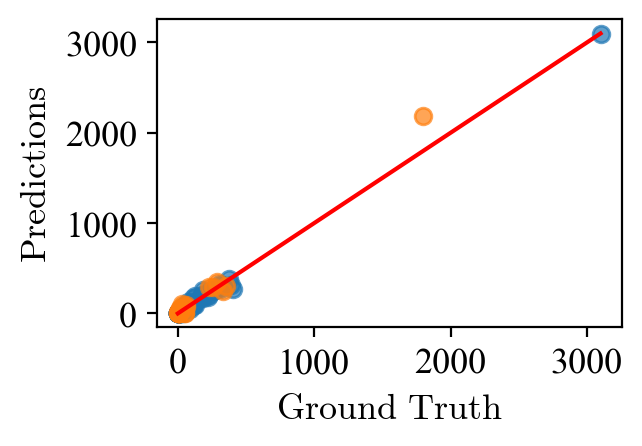

In [15]:
plot_data(train, test, data, target_col)

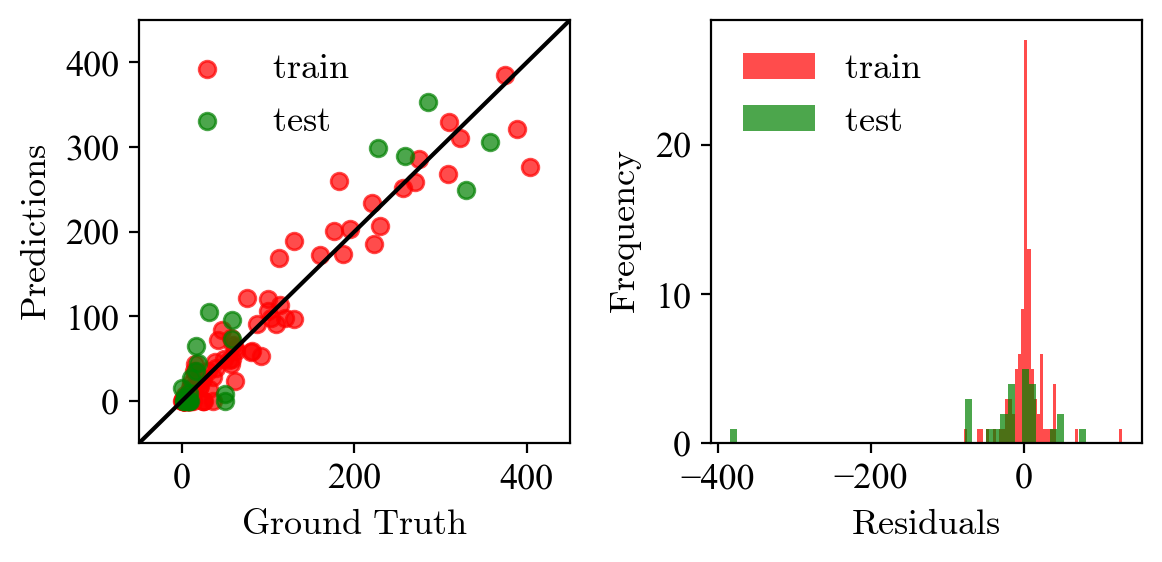

In [16]:
approach ='KCenterGreedy'
show_performance(train, test, method=approach, save_fig=True)

In [17]:
# write train, test to numpy
np.save(f'../reports/data/{approach}_train.npy', np.array(train, dtype=object), allow_pickle=True)
np.save(f'../reports/data/{approach}_test.npy', np.array(test, dtype=object), allow_pickle=True)